# Single Ring Neuron Experiment

## Imports

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.stats import norm
import matplotlib.pyplot as plt

## Equations

### Output Transform Function (Sigmoid)
$$z_{r}=f(v_{i})=\frac{1}{1+e^{-\beta (v_{i} - \mu)}}$$
$$\beta = 10; \mu = 0.2$$

In [2]:
def transform(v, beta, mu):
    return 1 / (1 + (np.e ** ((-1*beta) * (v - mu))))

### Activity Equation
$$\frac{dv_i}{dt}=\frac{1}{\tau}(-\lambda v_i+i_1-\alpha u_i)$$ 
$$\tau = 1.0; \lambda=0.5; \alpha = 0.2$$

### Deactivation Equation
$$\frac{du_i}{dt}=-\rho u_i+\frac{z_i}{c_k}$$
$$\rho=0.2$$

In [9]:
t = np.linspace(0, 20, 2000)
y0 = [0.0, 0.0]

def doodle(t, state, p):
    return [
        (1 / p['tau']) * ((-1 * p['lambda'] * state[0]) + p['i_1'] - (p['alpha'] * state[1])),
        (-1 * p['rho'] * state[1]) + (transform(state[0], p['beta'], p['mu']) / p['c_k'])
    ]

## Hyperparameter Tuning

Exploring effects of $i_1$ and $c_k$

Text(0.5, 1.0, 'Single Ring Neuron Dynamics with Baseline Parameters\ntau=1p0 - lambda=0p5 - i_1=0p2 - alpha=0p2 - rho=0p2 - c_k=5p0 - beta=40p0 - mu=0p1')

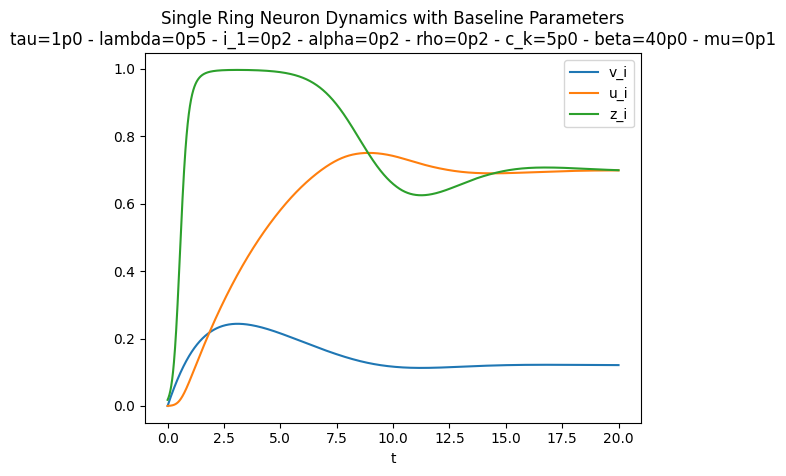

In [10]:
BASELINE_PARAMS = {
    'tau': 1.0,
    'lambda': 0.5,
    'i_1': 0.2,
    'alpha': 0.2,
    'rho': 0.2,
    'c_k': 5.0,
    'beta': 40.0,
    'mu': 0.1
}
result = solve_ivp(fun=lambda t, state: doodle(t, state, BASELINE_PARAMS), t_span=(0,20), t_eval=t, y0=y0)
fig,ax = plt.subplots()
ax.plot(t,result.y[0].T,label='v_i')
ax.plot(t,result.y[1].T,label='u_i')
ax.plot(t,transform(result.y[0], BASELINE_PARAMS['beta'], BASELINE_PARAMS['mu']).T,label='z_i')
ax.legend()
# ax.set_ylim([0, 1])
ax.set_xlabel('t')
ax.set_title(f"Single Ring Neuron Dynamics with Baseline Parameters\ntau={BASELINE_PARAMS['tau']}|lambda={BASELINE_PARAMS['lambda']}|i_1={BASELINE_PARAMS['i_1']}|alpha={BASELINE_PARAMS['alpha']}|rho={BASELINE_PARAMS['rho']}|c_k={BASELINE_PARAMS['c_k']}|beta={BASELINE_PARAMS['beta']}|mu={BASELINE_PARAMS['mu']}".replace('.','p').replace('|',' - '))

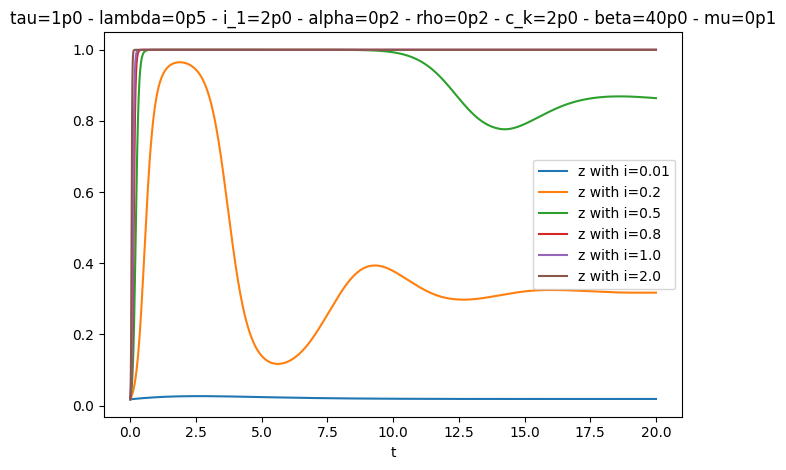

In [11]:
fig,ax = plt.subplots()
for i_1 in [0.01, 0.2, 0.5, 0.8, 1.0, 2.0]:
    params = {
        'tau': 1.0,
        'lambda': 0.5,
        'i_1': i_1,
        'alpha': 0.2,
        'rho': 0.2,
        'c_k': 2.0,
        'beta': 40.0,
        'mu': 0.1
    }
    result = solve_ivp(fun=lambda t, state: doodle(t, state, params), t_span=(0,20), t_eval=t, y0=y0)
    # fig,ax = plt.subplots()
    # ax.plot(t,result.y[0].T,label='v_i')
    # ax.plot(t,result.y[1].T,label='u_i')
    ax.plot(t,transform(result.y[0], params['beta'], params['mu']).T,label=f'z with i={i_1}')
    ax.legend()
    # ax.set_ylim([0, 1])
    ax.set_xlabel('t')
    ax.set_title(f"tau={params['tau']}|lambda={params['lambda']}|i_1={params['i_1']}|alpha={params['alpha']}|rho={params['rho']}|c_k={params['c_k']}|beta={params['beta']}|mu={params['mu']}".replace('.','p').replace('|',' - '))
    plt.tight_layout()
    # plt.savefig(f"plots\\tau={params['tau']}|lambda={params['lambda']}|i_1={params['i_1']}|alpha={params['alpha']}|rho={params['rho']}|c_k={params['c_k']}|beta={params['beta']}|mu={params['mu']}".replace('.','p').replace('|',' - '))
    # plt.show()